<a href="https://colab.research.google.com/github/bonareri/Bitcoin-Prediction-Analysis/blob/main/arima_sarima_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ARIMA

ARIMA (AutoRegressive Integrated Moving Average) is a model used to analyze and forecast time series data. It has three main components:

1. AR (AutoRegressive): Uses past values to predict the future.
2. I (Integrated): The differencing of raw observations to make the time series stationary.
3. MA (Moving Average): Uses past errors to predict the future. Best for stationary series

Key Parameters of ARIMA

- p: Number of past values (lags).
- d: Degree of differencing (to make data stationary).
- q: Moving average window size.

## 1. Import Preprocessed Data

In [18]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 29.1 MB/s eta 0:00:00


In [9]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
# Load preprocessed data
df = pd.read_csv('preprocessed_bitcoin_data.csv', index_col='Date', parse_dates=True)

# Display the first few rows of the data
df.head()

,Close,High,Low,Open,Volume,Close_diff,Close_scaled
Date,,,,,,,
2014-09-18,424.440002,456.859985,413.104004,456.859985,34483200,-32.894012,0.002325
2014-09-19,394.795990,427.834991,384.532013,424.102997,37919700,-29.644012,0.002045
2014-09-20,408.903992,423.295990,389.882996,394.673004,36863600,14.108002,0.002178
2014-09-21,398.821014,412.425995,393.181000,408.084991,26580100,-10.082977,0.002083
2014-09-22,402.152008,406.915985,397.130005,399.100006,24127600,3.330994,0.002114


## ARIMA Model

In [4]:
df.index = pd.to_datetime(df.index)  # Ensure it's a datetime index
df = df.asfreq('D')  # Set daily frequency (adjust if needed)

In [6]:
# Define ARIMA model with chosen (p, d, q)
model = ARIMA(df['Close'], order=(1, 0, 1))
arima_result = model.fit()

# Print model summary
print(arima_result.summary())


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3790
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -31408.819
Date:                Sat, 01 Feb 2025   AIC                          62825.638
Time:                        15:06:17   BIC                          62850.598
Sample:                    09-18-2014   HQIC                         62834.510
                         - 02-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.027e+04     16.231   1248.836      0.000    2.02e+04    2.03e+04
ar.L1          0.9998      0.000   3453.958      0.000       0.999       1.000
ma.L1         -0.0343      0.009     -3.927      0.0

In [13]:
# Forecast for the next 10 periods
forecast = arima_result.forecast(steps=10)
print(forecast)

2025-02-02    102028.334767
2025-02-03    102012.670839
2025-02-04    101997.009913
2025-02-05    101981.351986
2025-02-06    101965.697059
2025-02-07    101950.045132
2025-02-08    101934.396204
2025-02-09    101918.750273
2025-02-10    101903.107340
2025-02-11    101887.467405
Freq: D, Name: predicted_mean, dtype: float64


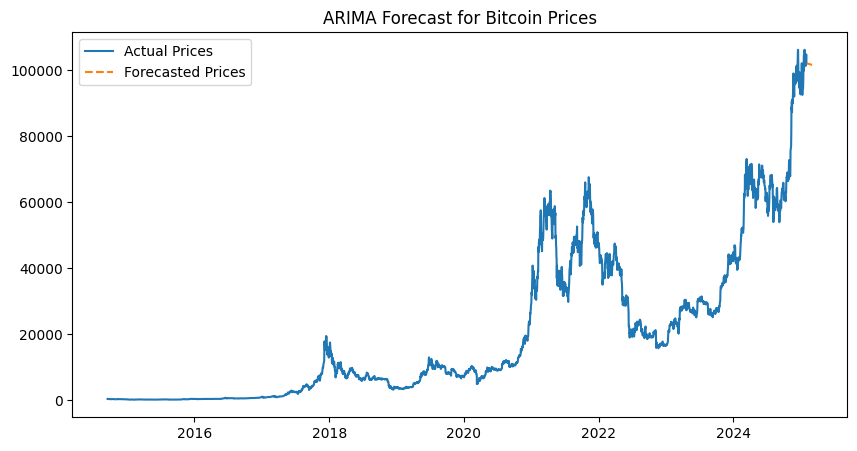

In [7]:
# Forecast future values
n_periods = 30  # Adjust based on how many days ahead you want to predict
forecast = arima_result.forecast(steps=n_periods)

# Plot actual vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['Close'], label='Actual Prices')
plt.plot(pd.date_range(df.index[-1], periods=n_periods+1, freq='D')[1:], forecast, label='Forecasted Prices', linestyle='dashed')
plt.legend()
plt.title('ARIMA Forecast for Bitcoin Prices')
plt.show()

## SARIMA

**SARIMA=ARIMA Model+Seasonal AR Terms+Seasonal MA Terms+Seasonal Differencing **

Extends ARIMA by adding seasonal components:
Seasonal AR and MA terms capture patterns that repeat over a fixed period (e.g., monthly, yearly).

Seasonal differencing removes repeating seasonal trends.

In [10]:
# Fit SARIMA model (example parameters: p=1, d=1, q=1, P=1, D=1, Q=1, s=12)
sarima_model = SARIMAX(df['Close'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_result = sarima_model.fit()

# Model summary
print(sarima_result.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                 3790
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood              -31332.986
Date:                            Sat, 01 Feb 2025   AIC                          62675.972
Time:                                    15:08:41   BIC                          62707.155
Sample:                                09-18-2014   HQIC                         62687.058
                                     - 02-01-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0000      5.704     -0.175      0.861     -12.180      10.180
ma.L1          1.0000      5.465   

### Forecasting:

In [11]:
# Forecast for the next 10 periods
forecast = sarima_result.forecast(steps=10)
print(forecast)

2025-02-02    102075.477818
2025-02-03    102145.260420
2025-02-04    102203.102805
2025-02-05    102216.322054
2025-02-06    102159.178072
2025-02-07    102127.891968
2025-02-08    102215.734558
2025-02-09    102204.612323
2025-02-10    102264.429721
2025-02-11    102298.925063
Freq: D, Name: predicted_mean, dtype: float64


### Plot Forecasts

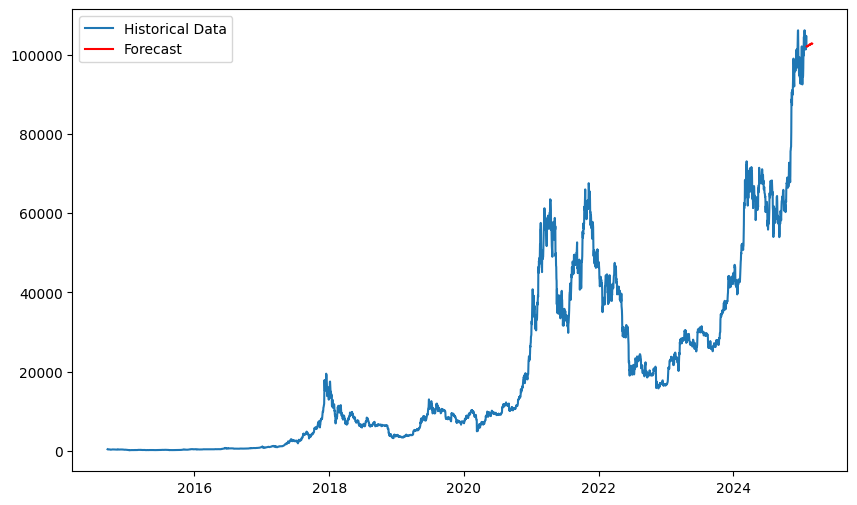

In [12]:
# Define forecast steps (number of periods you want to forecast)
forecast_steps = 30

# Generate the forecast
forecast = sarima_result.forecast(steps=forecast_steps)

# Create a new index for the forecast (adjust frequency based on your data's frequency)
forecast_index = pd.date_range(df.index[-1], periods=forecast_steps + 1, freq=df.index.freq)[1:]

# Plot actual vs forecasted values
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Close'], label='Historical Data')
plt.plot(forecast_index, forecast, label='Forecast', color='red')
plt.legend()
plt.show()

## Evaluate Model Performance

In [14]:
# Get in-sample predictions
df['ARIMA_Pred'] = arima_result.predict(start=0, end=len(df)-1)

# Compute errors
mae = mean_absolute_error(df['Close'], df['ARIMA_Pred'])

# Compute RMSE (Root Mean Squared Error)
mse = mean_squared_error(df['Close'], df['ARIMA_Pred'])
rmse = np.sqrt(mse)

# Print the error metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 474.20815847788344
Root Mean Squared Error (RMSE): 1013.0106395657398


In [15]:
# Get in-sample predictions from the SARIMA model
df['SARIMA_Pred'] = sarima_result.predict(start=0, end=len(df)-1)

# Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(df['Close'], df['SARIMA_Pred'])

# Compute Root Mean Squared Error (RMSE)
mse = mean_squared_error(df['Close'], df['SARIMA_Pred'])
rmse = np.sqrt(mse)

# Print the error metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 471.48538429563195
Root Mean Squared Error (RMSE): 961.615973019695


### Hyperparameter tuning

In [20]:
import pmdarima as pm
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Assume df is your DataFrame and 'Close' is the column you're forecasting

# Use auto_arima to automatically tune the SARIMA model.
# Adjust 'm' (seasonal period) as per your data frequency (e.g., m=12 for monthly data with yearly seasonality).
auto_model = pm.auto_arima(
    df['Close'],
    seasonal=True,
    m=12,               # seasonal period, adjust if needed
    start_p=0,
    start_q=0,
    max_p=2,
    max_q=2,
    d=None,             # let auto_arima determine the order of differencing
    start_P=0,
    start_Q=0,
    max_P=1,
    max_Q=1,
    D=None,             # let auto_arima determine the seasonal differencing
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

# Print the summary of the best model
print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=62799.015, Time=0.13 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=62792.065, Time=1.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=62792.808, Time=1.36 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=62799.967, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=62796.020, Time=0.09 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=62780.094, Time=4.80 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=62792.668, Time=1.74 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=62782.243, Time=2.79 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=62781.401, Time=4.79 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=62781.729, Time=7.14 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=62780.173, Time=3.84 sec
 ARIMA(2,1,1)(1,0,1)[12] intercept   : AIC=62783.686, Time=5.94 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=62780.870, Time=3.48 sec

Best model:  ARIMA(1,1,0)(1,0,1)[12] intercept
Total fit time: 37.418 se

In [ ]:
# Generate in-sample predictions
# Note: 'predict_in_sample' gives predictions for the training data.
df['SARIMA_Pred'] = auto_model.predict_in_sample(start=0, end=len(df) - 1)

# Calculate error metrics
mae = mean_absolute_error(df['Close'], df['SARIMA_Pred'])
mse = mean_squared_error(df['Close'], df['SARIMA_Pred'])
rmse = np.sqrt(mse)

# Print the error metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

### Forecast Future Values

In [ ]:
# Forecasting the next 12 periods
n_periods = 12
forecast, conf_int = auto_model.predict(n_periods=n_periods, return_conf_int=True)

# Create an index for the forecasted periods
# (adjust this to suit your DataFrame's datetime index or desired index)
forecast_index = pd.date_range(start=df.index[-1], periods=n_periods+1, freq='M')[1:]

# Create a DataFrame for the forecast
forecast_df = pd.DataFrame({
    'Forecast': forecast,
    'Lower CI': conf_int[:, 0],
    'Upper CI': conf_int[:, 1]
}, index=forecast_index)

print(forecast_df)